<b><u>Test details</u></b>

 

Consider the following scenario: a process generates a set of sequences, each sequences is encoded as a sequence of characters.   There is an <b>undisclosed number of distinct processes </b>so it should be possible to group the sequences into clusters of similar sequences.   However, in addition some sequences have been generated by another unrelated process to form <b>outliers </b>.   Each instance is either an inlier or an outlier. 

 

You have two tasks: task 1 is to <b>cluster the inliers into an appropriate number of groups</b>; task 2 is to <b>generate a novel prototypical sequence for each cluster</b>, i.e. a sequence that is the most representative for that cluster. Note that the prototypical sequence must be <b>novel</b>, i.e. not be one of the provided sequences.

 

You may use any machine learning library, or software packages. We provide a single text file, test.txt,   which contains a random mixture of inlier and outlier sequences in no particular order.   Each row of this contains an integer identifier for the sequence and the sequence itself.  

 

Please organise and execute your code in a Jupyter/IPython notebook and provide cells where you 
1) print for <u>each sequence’s identifier together with the cluster ID they belong or that they are an outlier</u>, and 
2) print <u>one novel prototypical sequence for each cluster you have found</u>.


# 1. Data import & exploratory
We will read the text file <i>line by line</i>, then store it in a <u>list</u>. We will also take a look at the distribution & attributes.

In [1]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings('ignore')

# from google.colab import drive

# drive.mount('/content/drive')
# file_path = "/content/drive/My Drive/Colab Notebooks/sides/jobs related/exeter_ktp/test.txt"

os.chdir("C:\\Users\jsl3a\Desktop\Jobs\Exeter KTP")
file_path = 'test.txt'

print(os.getcwd())

C:\Users\jsl3a\Desktop\Jobs\Exeter KTP


In [2]:
#open the file
with open(file_path, 'r') as file: #change to 
    #initialize an empty list to store the lines
    lines = []

    #iterate over each line in the file
    for line in file:
        #remove additional space before each line
        line = line.strip()
        #remove the indentifier(numbers before each line) and the space by slicing
        modified_line = line.split(' ', 1)[-1].strip()
        #append the strings we want to the list
        lines.append(modified_line)

#print all lines (with index) to check
for index, line in enumerate(lines):
    print(f"{index}: {line}")

0: DIFHDGDDGDEGGDGDDIEGIEFHDFGEFIDDGEFIGIDGEIEIEIGFIHEDDFEDFGGEGDDEGGIGIFIHDEIDDDEDGDEEGIDEDGIFHDDGEFIEDEFDFFDDIDFEGIIDDFFEI
1: DIDHDFGDGDDEFEDGDDDHDEGIEGIDGGEFHIDGGFIGDDGEIEFIFFIEHEDDFEDIGGEGDDEGDDGIFDHDEFDGDEDGDEEGIFEDEIFHIDIEFFEDEFIIFGIIDIIGIGDDFFEIDEDGEFGFFHGD
2: IGEEDEFGGIHDGIFHDGDDEFEDGDDHIIEGIGEHDFIIFIDDGEFIGDDFEIFFFFGIEHEDGFFDFGFDGDDEGDDGGFDDDEIGGEEDGDEEGIGEDDDEHDDGGFIEDEFDIFDEIDFEGIIDIFDEDIEDIEFGFFHI
3: FIFEEDDFGFGGDDIFHDGDDGEEDGDDGIIEGFEEHEFGIFEDDGFFFGGDDEIEFFFGGEHEDDFEDFGGEDDGEGHIGIIDHDEIDHDEDIDEEGIGEDGIIDDDGIFIEDEFDIFDIIDFEGIIDDEFEDIFDGFFGFDHIDI
4: GFGFDGDGIFEDGDDEFEGFDDDEIGGIEEHDEGIEIDDGEEIGDDGIEEFFFGDEHEDDFIDFGGEHDDEGFIGEDIHDEIDGDEDGEEFGIGEDDIFHDDGHFIIDEFDIDDIIDFIGFIDDFGEIDEDGEFGFFHI
5: FDFEIDGFGFDDDGIFHFGDGGFEDGDDIIDEIIEDHDFGEFIDDGEFIIDDEEIEDFFGIEHEDDFEDDDGEGDDEGDGGIFDDDEDDGHEDGDEEGEGEDGIFHDIGEFIHDEFFGFDIIDFEGIIEDFFEIDEDGGFGFFHII
6: FEFDHEIEFHDGDDGIEDGDDDGIEGIEDHDFGIFIDDGEFIGDDGDFIFFFGIIHDDGFEDGIGEGDDEGDIGIFDHDEIDGDEDGDEEGIFEEGEFHDDGEFGIDEFDIFDIIDFEGIEDEFFDFDEDGEFGFFH
7:

Now that we have the lines in a list ready to be used, we can examine these text closely. Here are some initial findings:

1. The lines are of <u>various length</u>
2. They are of occurrences of the character "D", "E", "F", "G", "H", "I"

Lets quickly check the length and the number of occurrences of each character:

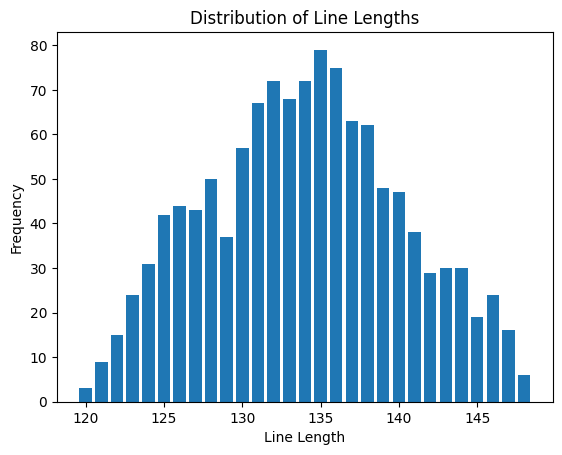

In [3]:
#initialize a dictionary to store line length counts
line_length_counts = {}

#iterate over each line in the 'lines' list
for line in lines:
    #get the length of the current line
    length = len(line)
    
    #increment the count for the current line length
    if length in line_length_counts:
        line_length_counts[length] += 1
    else:
        line_length_counts[length] = 1

#visualize the distribution using a histogram plot
plt.bar(line_length_counts.keys(), line_length_counts.values())
plt.xlabel('Line Length')
plt.ylabel('Frequency')
plt.title('Distribution of Line Lengths')
plt.show()


In [4]:
#initialize a dictionary to store character counts
character_counts = {'D':0,'E':0,'F':0,'G':0,'H':0,'I':0}

#iterate over each line in the 'lines' list
for line in lines:
    #iterate over each character in the line
    for char in line:
        #increment the count for the current character
        if char in character_counts:
            character_counts[char] += 1
        else:
            character_counts[char] = 1

#print the occurrences of each character
for char, count in character_counts.items():
    print(f"Character '{char}' occurs {count} times.")


Character 'D' occurs 43254 times.
Character 'E' occurs 28443 times.
Character 'F' occurs 26817 times.
Character 'G' occurs 28231 times.
Character 'H' occurs 8508 times.
Character 'I' occurs 25522 times.


We can see that the lines length is in the range of 120-148, with most falling between 130-140.

The occurrence of character "D" is the highest, "H" is the lowest while the rest of the characters "E", "F", "G", "I" are about the same.

# TASK 1: Clustering & Outlier Identifying

To cluster the lines of text, two approach comes to mind:
1. we do the <u>embedding manually</u>, e.g. by counting the <u>occurrences of the character</u> in each line, then embed the line with that. We can introduce <b>weights</b> to account for the occurrence <b>order</b> of characters. Then <u>vectorise</u> each line accordingly before using <b>k-means</b> or <b>mixture model</b> for clustering.
2. let <u>deep learning models</u> learn the embedding instead, and they will do the clustering according to the embedding they learn themselves.

The pros & cons:
1. simple and easily interpretable, but can be difficult to do task 2 as clustering models like k-means are not typically used for generation. We will require <b>another process for generation.</b>
2. seemingly effective as deep model can uncover embeddings that is hard to see with the human eye, and we can use for example VGAE to do the easy generation of novel sequences. The models can be <b>difficult to tune</b> for tho as there is no label and we might not have an idea <b>when to stop</b>. Also the <u>sample size is not big enough</u> for deep learning models, i.e. the models can be too complex for this simple data.

p.s. if the method 1 clustering work really well, we can try [1] for clustering and [2] for generation

##  1. vectorise manually
In this case we will try to vectorise each line. to do that, we will have to:
1. <u>count the occurrence</u> of character in each line
2. To simplify, we record it in a <u>new data structure </u> (e.g. D:10 E:12 F:11 G:22 H:13 I:8 represented as 10,12,11,22,13,8), in implementation we will add in <b>weights</b> to <b>increase significance of earlier occurrences</b>.
3. <u>normalise</u> using sklearn's StandardScaler()

There is 2 types of weighting in mind:
1. The weights of a single type of character is <b>independent</b> of each other. i.e., the importance of character "D" is <u>affected by if there is other "D" occur beforehand</u>, but not affect by other type of char before.
2. The importance/weight of a type of char is <b>dependent</b> of each other. i.e., the importance of character "D" is affected by <u>any other type of char before it</u>, be it "F" or "G" etc.

The common thing for these weighting is that for the <b>weight</b> used, the <u>lower the number</u>, the <u>less important is for latter characters</u>, vice versa

#### p.s. We are implementing <b>weight 2</b> as it performs better in the following steps. 

In [5]:
#create a dataframe to hold the lines
df = pd.DataFrame(lines, columns=["ori_text"])
df

,ori_text
0,DIFHDGDDGDEGGDGDDIEGIEFHDFGEFIDDGEFIGIDGEIEIEI...
1,DIDHDFGDGDDEFEDGDDDHDEGIEGIDGGEFHIDGGFIGDDGEIE...
2,IGEEDEFGGIHDGIFHDGDDEFEDGDDHIIEGIGEHDFIIFIDDGE...
3,FIFEEDDFGFGGDDIFHDGDDGEEDGDDGIIEGFEEHEFGIFEDDG...
4,GFGFDGDGIFEDGDDEFEGFDDDEIGGIEEHDEGIEIDDGEEIGDD...
...,...
1195,GEDHDGEFEFEIGDIDDGFGGFDGDDFGGDGFDGFEIDGGFFDGIE...
1196,FEFEIGDIDDGFEGFDGDDEFEDGFDDGFEDDGEFIGIEIIDEDEE...
1197,DEIIGDGGIEGFEFEIGDGDDGGEGFDDIDIGFDGGFGFFIEDFEH...
1198,GDDHGEEFEFEIFDEDDGFEGFDDDDIGGDGFDGFFIDEGEFFGGE...


As mentioned earlier, we are defining a function below to process the data. The function takes in a Dataframe, for each line/sequence, it will record the weightage of each character, then finally <u>return a new Dataframe with the weights recorded</u>.

In [6]:
def transform_df(df):
    transformed_lines = []
    for line in df["ori_text"].values:
        #initialize a dictionary to store character counts for the current line
        char_counts = {'D':0,'E':0,'F':0,'G':0,'H':0,'I':0}

        #count the length of the line
        line_length = len(line)

        i=1

        #iterate over each character in the line
        for char in line:
            #increment the count for the current character
            #new weighted way: for each new time a char repeat it will add a fraction of points (0.3), hence:
            if char_counts[char]>0:
                #weight type 2
                char_counts[char] += 0.3**i #if <0, latter char less important, >0 then latter char more important (max is 1.05ish?), 1 means non weighted
            else:
                char_counts[char] = 0.01 #if first occurrence, give relatively big weight.
            i+=1

        #append the transformed line as a list of total counts
        transformed_lines.append(list(char_counts.values()))
        #converts list into dataframe
        df_dim6 = pd.DataFrame(transformed_lines, columns=["D","E","F","G","H","I"])
        
    return df_dim6

df_transformed = transform_df(df)
df_transformed

,D,E,F,G,H,I
0,0.012720,0.010000,0.010000,0.010020,0.01,0.010000
1,0.039503,0.010000,0.010000,0.010020,0.01,0.010000
2,0.010001,0.018829,0.010000,0.010085,0.01,0.010006
3,0.010219,0.012430,0.037072,0.010002,0.01,0.010000
4,0.010219,0.010000,0.018106,0.037795,0.01,0.010000
...,...,...,...,...,...,...
1195,0.012430,0.010240,0.010006,0.010729,0.01,0.010000
1196,0.010026,0.018100,0.037001,0.010002,0.01,0.010066
1197,0.010729,0.010006,0.010000,0.010286,0.01,0.018120
1198,0.037000,0.010240,0.010006,0.012430,0.01,0.010000


We then perform the <u>normalisation</u> of the new Dataframe using sklearn's StandardScaler.

In [7]:
from sklearn.preprocessing import StandardScaler

#initialize the StandardScaler
scaler = StandardScaler()

#fit the scaler to the transformed data
scaler.fit(df_transformed)

#transform the data using the scaler
scaled_df_transformed = scaler.transform(df_transformed)

#convert the scaled array back to a DataFrame
scaled_df_transformed = pd.DataFrame(scaled_df_transformed, columns=df_transformed.columns)

#print the scaled DataFrame
print("Scaled DataFrame:")
print(scaled_df_transformed)


Scaled DataFrame:
             D         E         F         G         H         I
0    -0.392840 -0.312314 -0.281993 -0.259115 -0.084563 -0.314465
1     0.525280 -0.312311 -0.281981 -0.259175 -0.084563 -0.314465
2    -0.486072  0.174803 -0.281992 -0.253610 -0.084561 -0.314142
3    -0.478586 -0.178245  1.700384 -0.260646 -0.084563 -0.314464
4    -0.478573 -0.312314  0.311582  2.090971 -0.084563 -0.314465
...        ...       ...       ...       ...       ...       ...
1195 -0.402788 -0.299064 -0.281561 -0.199144 -0.084563 -0.314464
1196 -0.485213  0.134591  1.695187 -0.260686 -0.084563 -0.310912
1197 -0.461100 -0.311979 -0.281989 -0.236634 -0.084563  0.125244
1198  0.439469 -0.299063 -0.281549 -0.055230 -0.084563 -0.314465
1199 -0.486072  4.694511 -0.103917 -0.260827 -0.084563 -0.314145

[1200 rows x 6 columns]


Next we perform <b>Principle Component Analysis (PCA)</b> to lower the dimension of the data, so that it works well with clustering methods like k-means and is easy to visualise.

In [8]:
pca = PCA(n_components=2)
pca.fit(scaled_df_transformed)

#transform the normalized data into the PCA space
df_pca_scaled = pd.DataFrame(pca.transform(scaled_df_transformed), columns=['PC1', 'PC2'])
print(df_pca_scaled)

           PC1       PC2
0    -0.007433 -0.001041
1    -0.758799 -0.078951
2     0.225746 -0.293747
3     0.843325 -0.466216
4     0.745401  0.350111
...        ...       ...
1195  0.016887  0.003254
1196  0.947605 -0.655961
1197  0.150561  0.329024
1198 -0.644111 -0.040015
1199  1.735536 -3.131556

[1200 rows x 2 columns]


### PCA visualisation of the processed data:

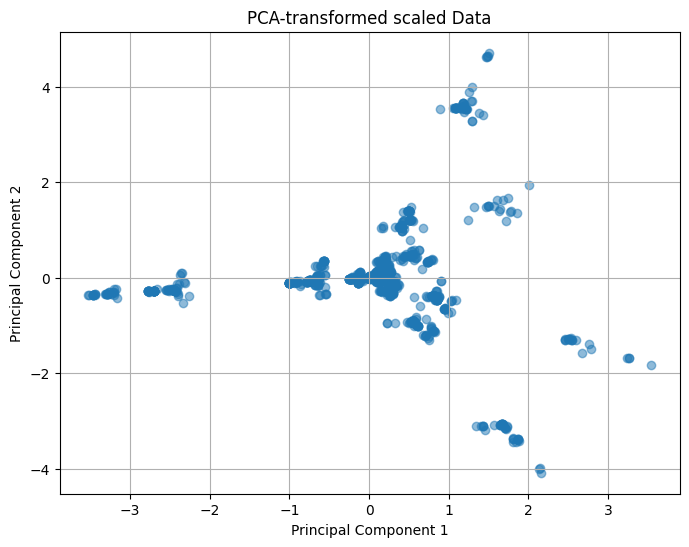

In [9]:
#plot the PCA-transformed scaled data
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_scaled['PC1'], df_pca_scaled['PC2'], alpha=0.5)
plt.title('PCA-transformed scaled Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

The clusters seems *pronounced* here. we will proceed with this data. the groups seems to be somewhere in the range of 10-12?

## K-Means Clustering

### To determine the optimal k value, we run an algorithm below
we aim to use the elbow method to plot the inertia value as we loop through a range of candidate k value:

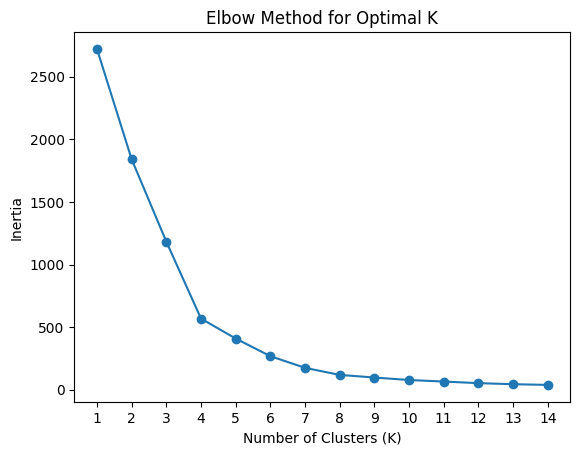

In [10]:
#define a range of k values to test
k_values = range(1, 15)  # Test k values from 1 to 10
df=df_pca_scaled

#initialize an empty list to store inertia values
inertia_values = []

#loop through each k value
for k in k_values:
    #initialize KMeans with the current k value
    kmeans = KMeans(n_clusters=k)
    
    #fit KMeans to the data
    kmeans.fit(df)
    
    #append the inertia value to the list
    inertia_values.append(kmeans.inertia_)

#plot the inertia values for different k values
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

seems to confirm our hypothesis that the optimal value lies somewhere <u>between 10-12</u>, lets plot to check...

kmeans10 inertia:  77.84863483333466
kmeans11 inertia:  65.47684957147949
kmeans12 inertia:  52.719430079592854
kmeans13 inertia:  44.39010876456467


Text(0.5, 1.0, 'kmeans13')

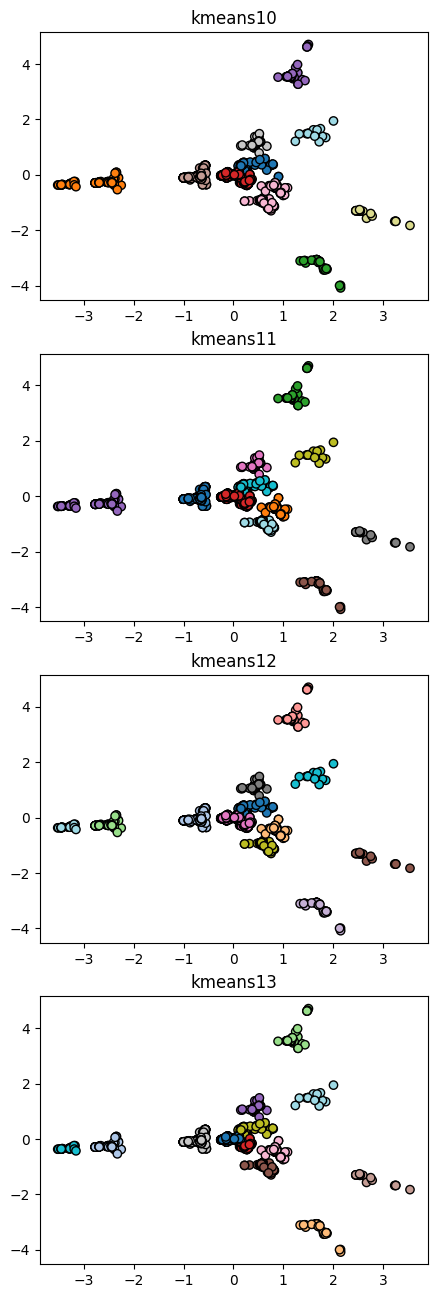

In [11]:
kmeans10 = KMeans(n_clusters=10)
kmeans10.fit(df_pca_scaled)

kmeans11 = KMeans(n_clusters=11)
kmeans11.fit(df_pca_scaled)

kmeans12 = KMeans(n_clusters=12)
kmeans12.fit(df_pca_scaled)

kmeans13 = KMeans(n_clusters=13)
kmeans13.fit(df_pca_scaled)

print("kmeans10 inertia: ",kmeans10.inertia_)
print("kmeans11 inertia: ",kmeans11.inertia_)
print("kmeans12 inertia: ",kmeans12.inertia_)
print("kmeans13 inertia: ",kmeans13.inertia_)

fig, axes = plt.subplots(4, 1, figsize=(5, 16))

axes[0].scatter(df_pca_scaled.PC1, df_pca_scaled.PC2, cmap='tab20', c=kmeans10.labels_, edgecolor='k')
axes[0].set_title("kmeans10")
axes[1].scatter(df_pca_scaled.PC1, df_pca_scaled.PC2, cmap='tab20', c=kmeans11.labels_, edgecolor='k')
axes[1].set_title("kmeans11")
axes[2].scatter(df_pca_scaled.PC1, df_pca_scaled.PC2, cmap='tab20', c=kmeans12.labels_, edgecolor='k')
axes[2].set_title("kmeans12")
axes[3].scatter(df_pca_scaled.PC1, df_pca_scaled.PC2, cmap='tab20', c=kmeans13.labels_, edgecolor='k')
axes[3].set_title("kmeans13")

the metrics shows that there is a *dropoff of improvement* starting from k=12 to k=13, we will proceed with <b>k=12</b>\
Next, we try to list the <u>distance</u> of the datapoints from their respective centroids to look for <b>outliers</b>:

In [12]:
#get the distances of each point to its assigned cluster centroid
cluster_labels = kmeans12.labels_
cluster_centers = kmeans12.cluster_centers_
distances = np.linalg.norm(df_pca_scaled.values - cluster_centers[cluster_labels], 2, axis=1)

#sort the distances in descending order
sorted_distances_indices = np.argsort(distances)[::-1]

#print the indices of data points with largest distances (potential outliers)
print("Indices of potential outliers:")
print(sorted_distances_indices)


Indices of potential outliers:
[ 218  852 1061 ...  898  887  947]


In [13]:
out=0
for ind in sorted_distances_indices:
    if distances[ind] >= 0.6:
        out+= 1
    print(distances[ind])

1.059803643771853
0.997958973288507
0.9828924636291934
0.9679089064831388
0.9660063024283356
0.9533719031030372
0.923453168843564
0.8696711007358703
0.8672321935184724
0.6060005065860867
0.6007853468998586
0.5999142868274063
0.5821442180315277
0.4648924527927671
0.44246438939929267
0.434595332958901
0.43252235291255375
0.431410315023687
0.4299917315356001
0.4299890652348742
0.4299553202697464
0.4296049692288351
0.42721310001128243
0.42462352212613047
0.4236676078918716
0.42365254743811015
0.41929448795960395
0.41922192034914046
0.4184950729496676
0.4088774393222548
0.4066157496869565
0.406163540181349
0.4056918570549221
0.4034200378489049
0.40179016025661
0.39618656075225933
0.39137796134449854
0.3904586319032683
0.3903748993146659
0.39006935721000524
0.3893683505531381
0.3893602498381
0.38508243689212485
0.3850474927897984
0.38377098865401377
0.3832689928673421
0.38284431157543053
0.3790102897415215
0.3789903707637685
0.37893929857113723
0.37893799812885637
0.37836110564041386
0.37813

the range of distance is from 1.05~0.002, with a significant dropoff present at around 0.6 to 0.4. We will <b>set the cutoff to 0.6</b> first.

In [14]:
print("number of outlier (distance>=0.6):", out)

number of outlier (distance>=0.6): 11


With the threshold distance for outlier *decided*, we then label the outliers, then create a final_df with only the original text and their labels

In [15]:
#define a threshold for identifying outliers
threshold_dist = 0.6  # Example threshold value for illustration
final_df = df_pca_scaled.copy()
final_df['label'] = cluster_labels

#initialize a copy of the cluster labels
modified_cluster_labels  = cluster_labels.copy()

#change the cluster labels of identified outliers to 12 （as the 13th group, we have 0-11）
modified_cluster_labels[distances > threshold_dist] = 12

#add the modified cluster labels as a new column to the DataFrame
final_df.drop(columns = ["label", "PC1", "PC2"], inplace=True)
final_df["ori_text"] = lines
final_df['labels_w_ol'] = modified_cluster_labels

#print the DataFrame with modified cluster labels
print("DataFrame with Modified Cluster Labels:")
print(final_df)

DataFrame with Modified Cluster Labels:
                                               ori_text  labels_w_ol
0     DIFHDGDDGDEGGDGDDIEGIEFHDFGEFIDDGEFIGIDGEIEIEI...            7
1     DIDHDFGDGDDEFEDGDDDHDEGIEGIDGGEFHIDGGFIGDDGEIE...            1
2     IGEEDEFGGIHDGIFHDGDDEFEDGDDHIIEGIGEHDFIIFIDDGE...            7
3     FIFEEDDFGFGGDDIFHDGDDGEEDGDDGIIEGFEEHEFGIFEDDG...            2
4     GFGFDGDGIFEDGDDEFEGFDDDEIGGIEEHDEGIEIDDGEEIGDD...            0
...                                                 ...          ...
1195  GEDHDGEFEFEIGDIDDGFGGFDGDDFGGDGFDGFEIDGGFFDGIE...            7
1196  FEFEIGDIDDGFEGFDGDDEFEDGFDDGFEDDGEFIGIEIIDEDEE...            2
1197  DEIIGDGGIEGFEFEIGDGDDGGEGFDDIDIGFDGGFGFFIEDFEH...            0
1198  GDDHGEEFEFEIFDEDDGFEGFDDDDIGGDGFDGFFIDEGEFFGGE...            1
1199  EEFDFEIGEIFDGFEGFDFHEIGGDGIDGFFIDHGDFGIIEIIDDF...            5

[1200 rows x 2 columns]


In [16]:
#take a look at the outliers
final_df[final_df["labels_w_ol"]==12]

,ori_text,labels_w_ol
103,GGGFDHDGIFHHGDDGGEDGDDFIGEGIEFHGFFIFIDDDEFIGDD...,12
126,EEEGFGFDHDGIFGGHIDGFEDGDDDIIGGIDDHDDFIFIGDEEFE...,12
218,IIIEIDEDDGEDEGIHIEGEFIDHDDGFEDFEGDEIIEFDIEFGEF...,12
703,EEEDEDHDDGDIDIIIFFEDIEFIFGGDDEDDFIEFDGDGEGDHHE...,12
752,IIIGFEDDDGFIGEGFHEGDFIEFHDGGEGDDDEGFIDIEFEEHGD...,12
852,IIIGDIHGEEFEFEIGDIDIDFEGFDDGGIGDDGFDDFFIDDGEFG...,12
1061,IIIGDGHGEEFEGEIHDIDDGDEGFDGDDIGGDGFDGFFIFDGFDG...,12
1104,IIIGDFHGEEFEFEDIDIIDGFEIFDGGDIGGDGFDDDFGDDGEFG...,12
1114,FFFFFIGDIDDGFEGFDGDDIGGDEEDGFFIDDGEIGGIEEGEEFG...,12
1135,FFFEIGDEDDGFIGIFDDDIEGIGFDDFDIDDGEFGGIIEIDEFGD...,12


In [17]:
#count the outliers
final_df[final_df["labels_w_ol"]==12].count()

ori_text       11
labels_w_ol    11
dtype: int64

having grouped the <b>outliers as label 12</b>, we try to visualize them again...

52.719430079592854


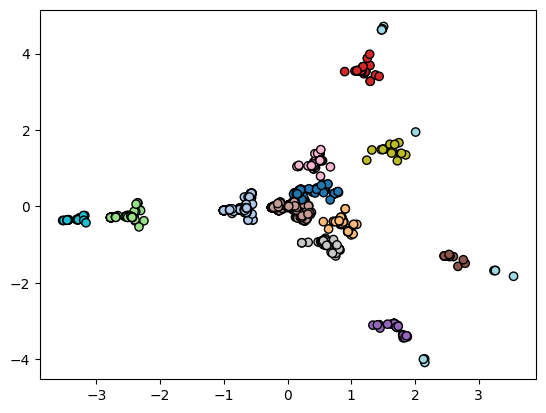

In [18]:
kmeans12 = KMeans(n_clusters=12)
kmeans12.fit(df_pca_scaled)

print(kmeans12.inertia_)
plt.scatter(df_pca_scaled.PC1, df_pca_scaled.PC2, cmap='tab20', c=final_df["labels_w_ol"], edgecolor='k')

As a comparison, we can also fit the *original data (scaled) with 6 dim* to a k-means with k=12 and check the inertia value:

In [19]:
kmeans12_o = KMeans(n_clusters=12)
kmeans12_o.fit(scaled_df_transformed)

print(kmeans12_o.inertia_)

356.55230276559803


the unscaled down data has a <u>much higher inertia value</u>!

## Answer for Task 1: print for each sequence’s <u>identifier</u> together with the <u>cluster ID</u> they belong or that they are an <u>outlier</u>,

In [20]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(final_df)

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

                                               ori_text  labels_w_ol
0     DIFHDGDDGDEGGDGDDIEGIEFHDFGEFIDDGEFIGIDGEIEIEI...            7
1     DIDHDFGDGDDEFEDGDDDHDEGIEGIDGGEFHIDGGFIGDDGEIE...            1
2     IGEEDEFGGIHDGIFHDGDDEFEDGDDHIIEGIGEHDFIIFIDDGE...            7
3     FIFEEDDFGFGGDDIFHDGDDGEEDGDDGIIEGFEEHEFGIFEDDG...            2
4     GFGFDGDGIFEDGDDEFEGFDDDEIGGIEEHDEGIEIDDGEEIGDD...            0
5     FDFEIDGFGFDDDGIFHFGDGGFEDGDDIIDEIIEDHDFGEFIDDG...            2
6     FEFDHEIEFHDGDDGIEDGDDDGIEGIEDHDFGIFIDDGEFIGDDG...            2
7     IDFFGFEHDGIFDFGDDGFEDGDDDIIFGDEEHDDGIFIDDDEFIG...            7
8     EEDGFDFDDGGDFHDFGGGFEDGDHDIIEGDEEHDFDGFIDDDEFI...            5
9     FFEDGFFFDHDGIDHDDDDGFEDGDDIDIEGIEEHDFEIGIDDGEF...            6
10    EDGFGFDHDGIFHDGDDFIEDGDDDIFEGIEEHFFGDFIDDGEFIG...            7
11    HDGIFHDGGDGFEDEDDDIIDGIEEHDFGIFIDIDEFFGGGGEIEF...            7
12    GFGFDIFGIFDDDDDGFEDGDDDIIGGIEEHDFFIFIDHGEEIGDD...            0
13    GIFFEGGFEFDHDHIFHDGDDGEGDGDD

# TASK 2: text generation

### Methods proposed
1. For a simple, tried and true implementation suitable for the case, I think a <i><b>[markov chain model](https://builtin.com/machine-learning/markov-chain)</b></i>, which deals specifically with <b>sequential data</b>, will perform well. This model is easy to implement: we need only a pair of information to perform generation, a <u>transition matrix</u> and <u>initial state vector</u>.

    we can obtain the transition matrix by reading through all the sequences to acquire the <b>probability</b> of one character given its previous one character. As for the initial state vector, we can get a *list of first character* from the sample and randomly choose one to start with. 

<u>Other honourable mentions</u> for generative methods (mainly deep learning) that may not be entertained (due to lack of time, sample size etc.) includes:


2. <b>RNN network</b>, specifically an <b>LSTM</b> architecture, deals with <b>sequences of character</b>, so learning the temporal patterns could lead to good generation overall (*if we have more data, the scale for deep learning*). One model that pooped up looking promising is char-rnn.

    ~char-rnn is by Andrej Karpathy, and is said to be able to learn from a large chunk of text and then generate similar text one character at a time, suiting our needs here. The source code for char-rnn can be found in this [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)~

    ~one other (much recent) text generation framework referenced is by [Jason Brownlee](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/) who uses a LSTM RNN model as well to generate text. The whole dataset is used, without splitting to training or testing set. His loss of choice is categorical_crossentropy. Used tensorflow keras~

However, since we are working with <b>incredibly small sample size</b> here (for the context of ML), especially after splitting the data to 12 clusters, the learning of deep models and generation is probably not going to be good.

~If one still insist on the ML route, there is 2 approach that comes to mind...~
1. ~we use 12 different models, each learn from a single cluster text, then generate within distribution. For that, we will have to create 12 new dataframes with unique cluster labels. We will use the current char as input, and next char as output.~
2. ~we train 1 single model and include cluster label as input. we will then use current char~

#### we will proceed with the Markov Chain method.

### data preparation

In [21]:
#check min/max length of lines
final_df["length"] = final_df["ori_text"].apply(lambda x: len(x)) # calculate len
print("the shortest sequence from this df has a length of: ", final_df["length"].min())
print("the longest sequence from this df has a length of: ", final_df["length"].max())

the shortest sequence from this df has a length of:  120
the longest sequence from this df has a length of:  148


In [22]:
# #adding space to all the shorter ones
# final_df["ori_text"] = final_df["ori_text"].apply(lambda x: x.ljust(148))# add padding
# final_df["length"] = final_df["ori_text"].apply(lambda x: len(x)) # update length
# print("the shortest sequence from this df has a length of: ", final_df["length"].min())
# print("the longest sequence from this df has a length of: ", final_df["length"].max())

Next we <b>split the data</b> to 12 groups, which allows us to apply the markov chain model to *12 different clusters*, fulfilling the aim to generate 12 different novel sequence for each cluster.

In [23]:
df_train = final_df.copy()

df_train0 = df_train[df_train["labels_w_ol"]==0].copy()
df_train1 = df_train[df_train["labels_w_ol"]==1].copy()
df_train2 = df_train[df_train["labels_w_ol"]==2].copy()
df_train3 = df_train[df_train["labels_w_ol"]==3].copy()
df_train4 = df_train[df_train["labels_w_ol"]==4].copy()
df_train5 = df_train[df_train["labels_w_ol"]==5].copy()
df_train6 = df_train[df_train["labels_w_ol"]==6].copy()
df_train7 = df_train[df_train["labels_w_ol"]==7].copy()
df_train8 = df_train[df_train["labels_w_ol"]==8].copy()
df_train9 = df_train[df_train["labels_w_ol"]==9].copy()
df_train10 = df_train[df_train["labels_w_ol"]==10].copy()
df_train11 = df_train[df_train["labels_w_ol"]==11].copy()

In [24]:
#create a list to reduce redundancy when we use these df later
traindf_list = [df_train0, df_train1, df_train2, df_train3, df_train4, df_train5,
               df_train6, df_train7, df_train8, df_train9, df_train10, df_train11]

for df in traindf_list:
    print(df.shape)

(108, 3)
(164, 3)
(69, 3)
(71, 3)
(38, 3)
(38, 3)
(17, 3)
(501, 3)
(68, 3)
(68, 3)
(16, 3)
(31, 3)


## Markov Chain

### Transition Matrix & Generation
we will define 4 functions:
1. <b>*trans_matrix*</b> to generate a <b>transition matrix</b> when given a df, where we will input df_train0-11 from above;
2. <b>*generate_sequence*</b> to generate a <b>new sequence</b> based on the <u>transition matrix</u> created, other argument includes length of generation and a start character;
3. <b>*head_prob*</b> is similar to trans_matrix, but takes <u>only the first character</u> of all sequence and output the <b>probability</b> distribution of first char;
4. <b>*new_seq_from_df*</b> to combine the above three functions, also including <u>randomizing the new sequence length</u>, from the df's own distribution.

In [25]:
#takes a df, read the ori_text and output a transition matrix
def trans_matrix(df, lines_of_strings, chars, char_to_idx, idx_to_char):  

    #for each line in lines_of_strings, convert the char to its index
    sequences = [[char_to_idx[char] for char in line] for line in lines_of_strings]
    #output is 2D matrix, 1st dim is individual sequences, 2nd dim is full list

    #construct transition matrix
    num_chars = len(chars)
    transition_matrix = np.zeros((num_chars, num_chars)) #6x6
    #record all transitions to the matrix
    for sequence in sequences:
        for i in range(len(sequence) - 1):
            current_char = sequence[i]
            next_char = sequence[i + 1]
            transition_matrix[current_char, next_char] += 1

    #normalize transition matrix to get probabilities
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    return transition_matrix
    
#generate a new seq in num, takes in start index (0-5)
def generate_sequence(start_char_idx, length, trans_mx, num_chars):
    #new list with given idx as start_char_idx
    sequence = [start_char_idx]
    current_char_idx = start_char_idx

    for _ in range(length - 1):
        #pull a random choice from num_chars(0-5), with probability from slice(current_char_idx) of trans_mx, p needs to be 1D and same size as num_chars
        next_char_idx = np.random.choice(num_chars, p=trans_mx[current_char_idx])
        sequence.append(next_char_idx)
        current_char_idx = next_char_idx

    return sequence

#is really just a duplicate of trans_matrix above, there's room for code refinement
#takes a df, read the ori_text all first char and output probability
def head_prob(df, chars, char_to_idx, idx_to_char):
    #get first char list from all sequences
    head_lines_of_strings = df["ori_text"].str[0]

    #for each line in lines_of_strings, convert the char to its index
    head_sequences = [[char_to_idx[char] for char in line] for line in head_lines_of_strings]
    #output is 2D matrix, 1st dim is individual sequences, 2nd dim is full list

    #construct transition matrix
    head_num_chars = len(chars)
    prob = np.zeros(head_num_chars) #6xnan
    #record all transition to the matrix
    for sequence in head_sequences:
        current_char = sequence[0]
        prob[current_char] += 1

    #normalize transition matrix to get probabilities
    prob /= prob.sum()
    
    return prob

#generate new sequences
def new_seq_from_df(df):  
    lines_of_strings = df["ori_text"]
    #get the list of unique char
    chars = sorted(set("".join(lines_of_strings)))
    #count unique char
    n_chars = len(chars)
    #dictionaries for char to idx & vice versa
    char_to_idx = {char: idx for idx, char in enumerate(chars)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}
    #initiate transition matrix - makes things look cleaner
    tr_mx = trans_matrix(df, lines_of_strings, chars, char_to_idx, idx_to_char)
    #start with the first sequence in df
    new_string = df["ori_text"].values[0]
    #will loop as long as the generated string is in df
    while(new_string in df["ori_text"].values):
        #randomly start with a char, using distribution prob from its own start char list
        start_char_idx = np.random.choice(n_chars, p = head_prob(df, chars, char_to_idx, idx_to_char))
        #randomly decide the length of new sequence
        sequence_length = np.random.randint(df["length"].min(), df["length"].max())
        #generate list of num (as idx)
        new_sequence = generate_sequence(start_char_idx, sequence_length, tr_mx, n_chars)
        #join the list while converting idx to char, forming final output new seq
        new_string = "".join([idx_to_char[idx] for idx in new_sequence])# convert to char string
        check_str = new_string
    return new_string

# print(f"Novel sequence from cluster: {new_seq_from_df(df_train0)}")

## Answer for Task 2: print <u>one novel prototypical sequence </u> for <u>each cluster</u> you have found.

In [26]:
print("Novel sequences for each clusters are as below: \n")
new_seqs = []

for index, df in enumerate(traindf_list):
    qq = new_seq_from_df(df)
    new_seqs.append(qq)
    print(f"Cluster {index}: {qq}")

Novel sequences for each clusters are as below: 

Cluster 0: DEHHIDGDDGGDDDDFEDIDDDDGFEIHHFHDHDIGGFGHIDDDDIDDGGDDEEFGEGDGDEIIFHEIEGEFEGDEFDGEFFDDEFHDDDEIGGEIDDGEDGHFGIEFFGDFDFEDDFGIDDGEDDDDFEDIDFEDG
Cluster 1: IDEFEFIDDDEFFDDIGHEGDHGDHEHFDHDDGFGIFFDDHGDIGGGDGIDDGDEGDFDDIGEEDEIGIEGHFEDDDDDDGGDFIDDIDGGDDEEEEEEDEFGEDIDFGFEFGEIEEHGFDHFDDGIIG
Cluster 2: FEIIEGEIIGDFDDEIIDDEFGDGDIEFEFHDIFEDEDGFDGDDGFHHDEEGFDEFIEGIIGIEHGIHGIFHEEHIFDDEEFGHGDDFDFFIEIDDGDDEDIEIIIDDDGEDDFDDFEGFEFDDDEH
Cluster 3: DGGFGDEGFEHGDGFFEEDDGDFGEDEDDEFEDIDGHIFEGGGIIGIIIDEGEGFEFDDGDHHGFDIFDIEFGDDGIIGDIGFFDIEDHDHIFEDFDEFDEFFFIGGEFEEGIDFDEEFIEHGGEIDD
Cluster 4: IDDIFFGEFGFGFFFGEEFDGDGDHDHGHIDGIHDGIGDDDIEIDIDDDFGDEFEIFDDIGDHDDEDFDFEHEGFIIEFDGGDHFDGFDHFDIDEFGEFDDFIGGIDEDDDDFIGGDDGGIDDEHGGFHEFGIIDIEDE
Cluster 5: EHIIDDIDGFEIDHDHGEIDFFIEDDFEEIIEDEIDDGDEGFEDIEFGDEGIIGHDDEGIEHHFDIIIEDDDIGFEFFFDFHEGDEGGIDDGHEHFHHDFDEHDIFGDDFIEGFDIIDFHFDIIDG
Cluster 6: FIEFDDGIFHEIEDDGIEGIFDDFGDEHDDDDDDGFDIDEDGEDDEFGGEFDDIFGGDEIDIIFGDDEDGEEIIGDEGEFE

### generation quality evaluation
One way to evaluate the generation quality, not perfect but very simple, is to fit the new data along with old data to the *knn model*. if the <b>inertia is lower or has slight increase</b>, then the generation is of reasonably good quality.

In [27]:
#add all the new sequences to the final_df dataframe to form a new df
df_nq = final_df.copy()

for idx, seq in enumerate(new_seqs):
    new_row = {"ori_text":seq, "labels_w_ol":idx, "length":len(seq)}
    df_nq.loc[len(df_nq)] = new_row
    
df_nq

,ori_text,labels_w_ol,length
0,DIFHDGDDGDEGGDGDDIEGIEFHDFGEFIDDGEFIGIDGEIEIEI...,7,121
1,DIDHDFGDGDDEFEDGDDDHDEGIEGIDGGEFHIDGGFIGDDGEIE...,1,136
2,IGEEDEFGGIHDGIFHDGDDEFEDGDDHIIEGIGEHDFIIFIDDGE...,7,144
3,FIFEEDDFGFGGDDIFHDGDDGEEDGDDGIIEGFEEHEFGIFEDDG...,2,147
4,GFGFDGDGIFEDGDDEFEGFDDDEIGGIEEHDEGIEIDDGEEIGDD...,0,139
...,...,...,...
1207,HDFEIFFGEHDFGIFEGIDFGIDDFGDGIEEIGFGFIIEIFIDFGF...,7,147
1208,GIGDGEFDIDIEDIEDHDEGDIGEGEGFIHGGIHDFIGEIDFFDIF...,8,136
1209,EGGDEDGFDGEEDEFGGGDGEEGEDFDIDGGIEFGDEHDGGEIIGG...,9,131
1210,GFGIDIGEFFGGEFDDEIDEHGGGIFFDDHDIDDHDIGIEEDEGFE...,10,131


In [28]:
#transform the df to get weightage of unique chars
df_tnq = transform_df(df_nq)

scaler = StandardScaler()
#normalise the weightage
scaler.fit(df_transformed)
scaled_df_tnq = scaler.transform(df_tnq)
scaled_df_tnq = pd.DataFrame(scaled_df_tnq, columns=df_tnq.columns)

#print the scaled DataFrame
print(scaled_df_tnq)

             D         E         F         G         H         I
0    -0.392840 -0.312314 -0.281993 -0.259115 -0.084563 -0.314465
1     0.525280 -0.312311 -0.281981 -0.259175 -0.084563 -0.314465
2    -0.486072  0.174803 -0.281992 -0.253610 -0.084561 -0.314142
3    -0.478586 -0.178245  1.700384 -0.260646 -0.084563 -0.314464
4    -0.478573 -0.312314  0.311582  2.090971 -0.084563 -0.314465
...        ...       ...       ...       ...       ...       ...
1207 -0.486029 -0.311228 -0.212555 -0.260827 -0.082666 -0.314462
1208 -0.483633 -0.312284 -0.281993  2.229334 -0.084563 -0.313300
1209 -0.460420 -0.178115 -0.281992  2.042728 -0.084563 -0.314465
1210 -0.486090 -0.312305 -0.280116  2.042423 -0.084563 -0.274987
1211 -0.400480 -0.312281 -0.281561 -0.242335 -0.084563 -0.313390

[1212 rows x 6 columns]


In [29]:
pca_tnq = PCA(n_components=2)
pca_tnq.fit(scaled_df_tnq)

#transform the normalized data into the PCA space, lower dim of 2
df_pca_tnq = pd.DataFrame(pca_tnq.transform(scaled_df_tnq), columns=['PC1', 'PC2'])
print(df_pca_tnq)

           PC1       PC2
0     0.009917 -0.004782
1     0.762424 -0.071372
2    -0.216776 -0.312276
3    -0.826454 -0.479183
4    -0.816796  0.542077
...        ...       ...
1207 -0.091896 -0.012871
1208 -0.635732  0.699709
1209 -0.614664  0.557924
1210 -0.603779  0.672943
1211 -0.000595  0.001089

[1212 rows x 2 columns]


the inertia metric for k=12 k-means including new sequences:  57.594950469619796
the inertia metric for k=12 k-means excluding new sequences:  52.719430079592854


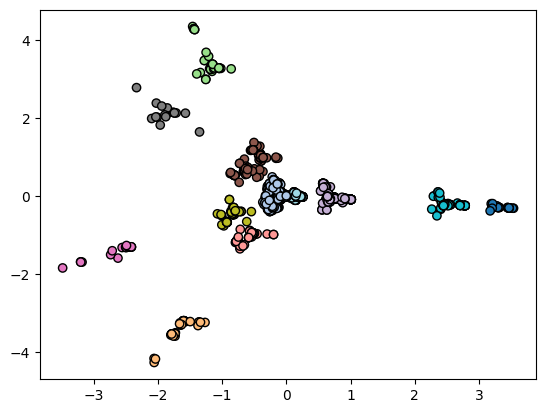

In [30]:
kmeans12_tnq = KMeans(n_clusters=12)
kmeans12_tnq.fit(df_pca_tnq)

plt.scatter(df_pca_tnq.PC1, df_pca_tnq.PC2, cmap='tab20', c=kmeans12_tnq.labels_, edgecolor='k')

print("the inertia metric for k=12 k-means including new sequences: ", kmeans12_tnq.inertia_)
print("the inertia metric for k=12 k-means excluding new sequences: ", kmeans12.inertia_)

With the inertia being slightly higher than original value, we can suggest that the generation is of good quality!

### ~Other approaches: LSTM~
~probs no time to execute?~

### ~data preparation~

In [31]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.utils import to_categorical

In [32]:
# #creating input and output data to fit into model
# #seq_length = 1 #using 1 here as we are not dealing with human language

# #function to get a list of input & output data from the training dataframe made above:
# def get_stackXY(df):
#     #dataX is number encoded, to be reshape from (147,1200(num of seq)) to (147,1200,1)
#     #dataY is onehot encoded, no need reshaping, keep shape of (147*1200, 6)
#     stackX = []
#     stackY = []
    
#     #for each sequence (of arrays)
#     for seq in df["ori_text"]: #take the original string
#         dataX = []
#         dataY = []
#         #for each char in the string 
#         for i in range(0, len(seq)-1):
#             #set current character
#             cur_char = seq[i]
#             nex_char = seq[i+1]
#             #set in sequence by checking dict2num
#             seq_in = np.array(dict2num[cur_char])
#             #set out sequence by checking dict2oh
#             seq_out = np.array(dict2oh[nex_char])
#             dataX.append(seq_in)
#             dataY.append(seq_out)
#         stackX.append(dataX)
#         stackY.append(dataY)
#     npStackX = np.array(stackX)/7 #normalise dataX cuz its ranged from 0-6
#     npStackY = np.array(stackY)
# #     npStackX = np.reshape(npStackX, (1, len(seq)-1, len(df)))
# #     npStackY = np.reshape(npStackY, (6, len(seq)-1, len(df)))
# #     print(npStackX.shape)
# #     print(npStackY.shape)
#     return npStackX, npStackY

# #testing the function
# # print(df_train1.shape)
# # stackX, stackY = get_stackXY(df_train1)
# # print(len(stackX), len(stackY))
# # print(stackX[0][:3])
# # print(stackY[0][:3])

In [33]:
# stackX1, stackY1 = get_stackXY(df_train1)
# #reshape data to array [sequence length=147, cluster sample size, dimension]:
# print(stackX1.shape)
# print(stackY1.shape)

### ~define model & train~ 

In [34]:
# #define the LSTM model
# model = Sequential()
# #return_sequences is True, because we are returning char by char, the output will be a sequence of the same length
# #ref: https://stackoverflow.com/questions/42755820/how-to-use-return-sequences-option-and-timedistributed-layer-in-keras
# model.add(LSTM(128, input_shape=(1, 1), return_sequences=True)) # small hidden layer, cuz the data is simple
# model.add(Dropout(0.2))
# model.add(Dense(stackY1.shape[2], activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam')

In [35]:
# #define the checkpoint
# filepath="checkpoints/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# # filepath="checkpoints256/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# # filepath="checkpoints128/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# # filepath="checkpoints64/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# # filepath="checkpoints32/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# # filepath="checkpoints16/weights-improvement-{epoch:02d}-{loss:.4f}.keras"
# checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
# callbacks_list = [checkpoint]

In [36]:
# lowest_loss = float('inf')

# start_time = time.time()

# for ep in range(100):
#     #fit the model for one epoch
#     history = model.fit(stackX1, stackY1, epochs=1, batch_size=1, verbose=0,
#                         callbacks=callbacks_list)
    
#     #update lowest loss if current loss is lower
#     if history.history['loss'][0] < lowest_loss:
#         lowest_loss = history.history['loss'][0]
#         print(f'epoch: {ep}, Lowest loss so far: {lowest_loss:.4f}')

# elapsed_time_min = (time.time() - start_time)/60
# print(f"Elapsed time: {elapsed_time_min:.2f} minutes")

In [37]:
# lowest_loss

~recording of hidden layer & loss from 100 epochs:\
h=256, l=1.546\
h=128, l=1.536\
h=64,  l=1.542\
h=32,  l=1.546\
h=16,  l=1.541~

~if needed we can fix the length of sequences(lines) by added empty ndarray to the end~

~also to be generative do we need mess with the start character, if it seems so indicative to the clusters? we can give the in data a space at the start to let the model start out of nowhere? from the framework we refer to, he used a random seed to start~

## Future Enhancement

1. tryout data preprocessing techniques like bigram or trigram, we can just make new dictionaries and reuse most of the code
2. tryout deep models like RNN & LSTM for generation tasks. 